In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from scipy.stats import norm
import matplotlib.pyplot as plt
from io import open
import glob
import os, sys
import unicodedata
import string
import time
import math
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from random import randint
from torch.autograd import Variable
import numpy as np
from numpy.random import shuffle
from common import *

from models.hanoi import *
from numpy.random import normal

In [3]:
def get_samples(size=1, imsize=64, 
                height=3, 
                shrink=[3/4, 1/3], # unique distribs 
                baseonly=False, tensor=True, device=None, concat=False):
    
    batch = []
    for ii in range(size):
        stack = []
        for hii in range(height):
            if hii == 0: # base is generated under slightly stricter constraints
                d0 = np.abs(normal(0, 5))
                s1 = imsize - d0 - 0.001
                y1 = max(min(normal((imsize - s1)/2, 1), imsize-s1), 0)
                x1 = max(min(normal((imsize - s1)/2, 1), imsize-s1), 0)
                stack.append([x1, y1, s1, s1])
            else:
                cursize = s1
                s1 = normal(cursize*shrink[hii-1], 7)
                s1 = min(s1, cursize - 0.001) # cannot exceed parent
                gap = cursize - s1
                y1 = max(min(normal(gap/2, 2), gap), 0)
                x1 = max(min(normal(gap/2, 2), gap), 0)
                stack.append([x1, y1, s1, s1])
                
        stack = [torch.FloatTensor([val/imsize for val in layer]) for layer in stack]
        batch.append(stack)
    return batch

def raster(stack, imsize=64):
    colors = [1.0 - 0.1 * ii for ii in range(len(stack))]
    canvas = np.zeros((imsize, imsize))
    yoffset, xoffset = 0, 0
    for ni, node in enumerate(stack):
        xx, yy, sizeX, sizeY = node.detach().cpu().numpy() * imsize
        canvas[
            int(yy+yoffset):int(yy+yoffset+sizeY), 
            int(xx+xoffset):int(xx+xoffset+sizeX)] = colors[ni]
        yoffset += yy
        xoffset += xx
    return canvas

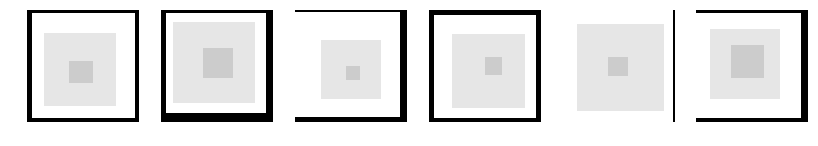

In [4]:
spreview = 6
samples = get_samples(spreview)

plt.figure(figsize=(14, 5))
for ii in range(spreview):
    plt.subplot(1, spreview, ii+1)
    plt.imshow(raster(samples[ii]), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.show()
plt.close()

In [5]:
def tonumpy(torch_stack):
    nplist = []
    for ent in torch_stack:
        nplist.append(ent.detach().cpu().numpy())
    return nplist

def coverage(stack):
    lvls = len(stack) - 1
    each = []
    for lii in range(lvls):
        s0, s1 = stack[lii:lii+2]
        ratioX = s1[2] / s0[2]
        ratioY = s1[3] / s0[3]
        each.append((ratioX, ratioY))
    return each

def centering(stack):
    def center_ratio(possible, actual):
        if possible < 0.0001: 
#             assert actual < 0.001
            return 0
        center = possible / 2
        offset = actual - center
#         print(possible, center, offset)
        normed = offset / center
#         print(normed)
#         try:
#             assert normed <= 1.1
#         except:
# #             print(possible, actual, normed)
#             assert False
        return normed
    
    lvls = len(stack) - 1
    each = []
    for lii in range(lvls):
        s0, s1 = stack[lii:lii+2]
        each.append((
            center_ratio(s0[2] - s1[2], s1[0]),
            center_ratio(s0[3] - s1[3], s1[1])))
    return each

def plot_coverage(stack_hist, dim, height=3, target=None, plot=True):
    if plot: plt.figure(figsize=(14, 3))

    if target is not None:
        for targ in target:
            plt.plot([-1, len(stack_hist)], [targ, targ], 'gray')
    
    for hii in range(height - 1):
        means = []
        errs = []
        for stage in stack_hist:
            covs = [coverage(tonumpy(stack))[hii][dim] for stack in stage]
            mu = np.mean(covs)
            var = np.var(covs)
            means.append(mu)
            errs.append(var)
        plt.errorbar(np.arange(len(means)), means, yerr=errs, fmt='-o')

    if np.min(means) > 0 and np.max(means) < 1:
        pass
    else: plt.ylim(0, 1)
    
    if plot: plt.show()
    if plot: plt.close()
    
def plot_centering(stack_hist, dim, height=3, plot=True):
    
    if plot: plt.figure(figsize=(14, 3))
        
    target = 0 # drift w/ reference to center
    plt.plot([-1, len(stack_hist)], [target, target])
    
    for hii in range(height - 1):
#     for hii in range(1):
        means = []
        errs = []
        for stage in stack_hist:
            covs = [centering(tonumpy(stack))[hii][dim] for stack in stage]
#             print(np.mean(covs), np.min(covs), np.max(covs))
            mu = np.mean(covs)
#             print(mu)
            var = np.var(covs)
            means.append(mu)
            errs.append(var)
        plt.errorbar(np.arange(len(means)), means, yerr=errs, fmt='-o')
        
    if np.min(means) > -1 and np.max(means) < 1:
        pass
    else: plt.ylim(-3, 3)
    if plot: plt.show()
    if plot: plt.close()

def plot_distrib(stack_hist, height=3, target=[3/4, 1/3], recent=None):
    if len(stack_hist) == 0: return
    if recent is not None: stack_hist = stack_hist[-recent:]
    plt.figure(figsize=(14, 3))
    
    plt.subplot(2, 2, 1)
    plot_coverage(stack_hist, 0, height, target, plot=False)
#     plt.gca().axis('off')
    plt.subplot(2, 2, 2)
    plot_coverage(stack_hist, 1, height, target, plot=False)
#     plt.gca().axis('off')
    
    plt.subplot(2, 2, 3)
    plot_centering(stack_hist, 0, height, plot=False)
#     plt.gca().axis('off')
    plt.subplot(2, 2, 4)
    plot_centering(stack_hist, 1, height, plot=False)
#     plt.gca().axis('off')
    
    plt.show()
    plt.close()


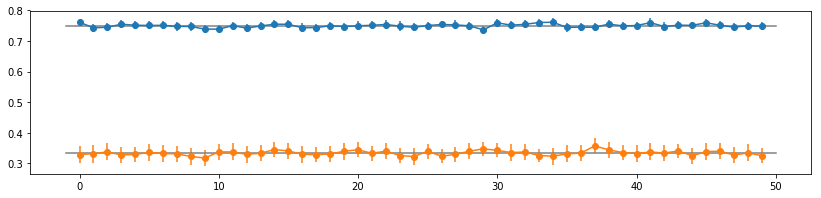

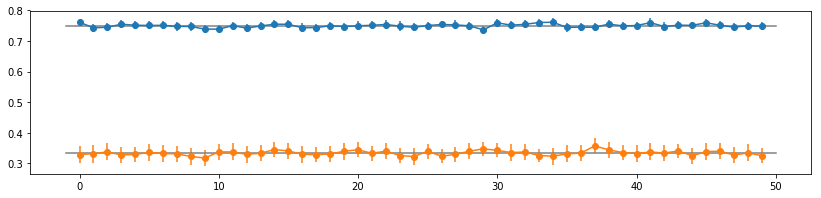

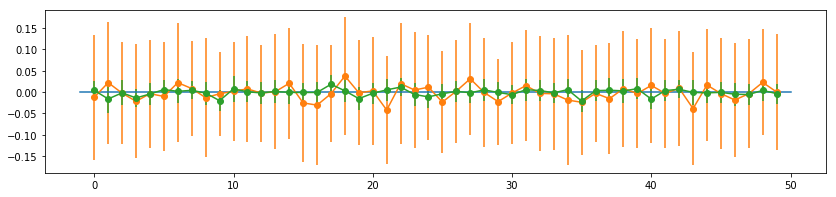

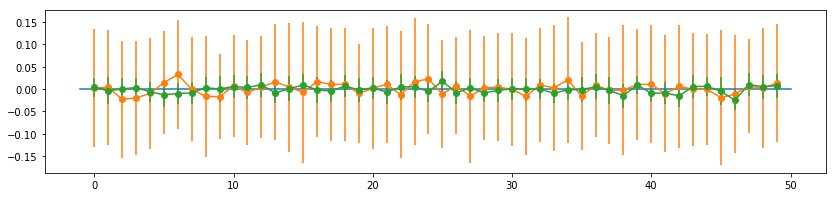

In [6]:
hist = [get_samples(500) for ii in range(50)]

plot_coverage(hist, dim=0, target=[3/4, 1/3])
plot_coverage(hist, dim=1, target=[3/4, 1/3])

plot_centering(hist, dim=0)
plot_centering(hist, dim=1)

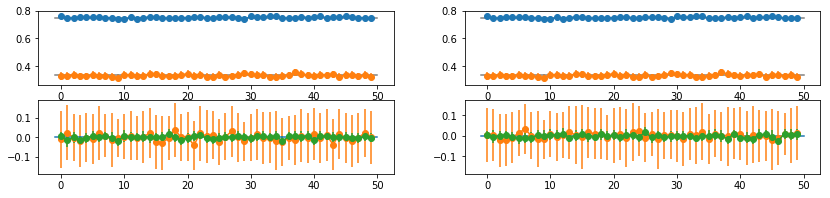

In [7]:
plot_distrib(hist)

In [8]:
LR = 1e-5
BSIZE = 64
bhalf = BSIZE // 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
real_labels = Variable(torch.ones(bhalf, 1), requires_grad=False).to(device)
fake_labels = Variable(torch.zeros(bhalf, 1), requires_grad=False).to(device)
device

device(type='cuda', index=0)

In [9]:
ZSIZE = 12
spawn = SpawnNet(hsize=4, zsize=ZSIZE, readsize=32).to(device)
discrim = DiscrimNet(readsize=32).to(device)
readout = ReadNet(hsize=4, readsize=32, hiddensize=256).to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
spawn.apply(init_weights)
discrim.apply(init_weights)
readout.apply(init_weights)

gen_opt = optim.Adam([
    { 'params': spawn.parameters() },
], lr=LR)

discrim_opt = optim.Adam([
    { 'params': discrim.parameters() },
], lr=LR)

readout_opt = optim.Adam([
    { 'params': discrim.parameters() },
    { 'params': readout.parameters() },
], lr=LR*0.1)

In [10]:
def get_readouts(stacks, detach=False):
    ros = []
    for stack in stacks:
        term = Variable(torch.zeros(32).to(device)) # readsize
        for hv in reversed(stack):
            if detach: hv = hv.detach()
            term = readout(hv.to(device), term)
        ros.append(term)
    return ros

samps = get_samples(100)
ros = get_readouts(samps)
print(ros[0].size())
        

torch.Size([32])


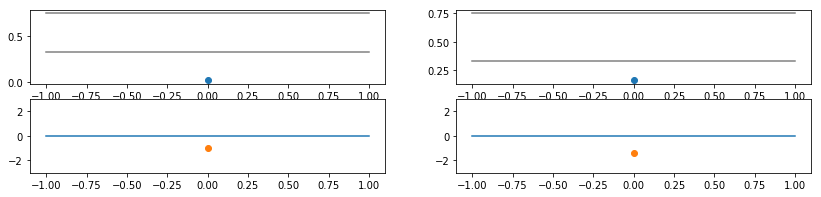

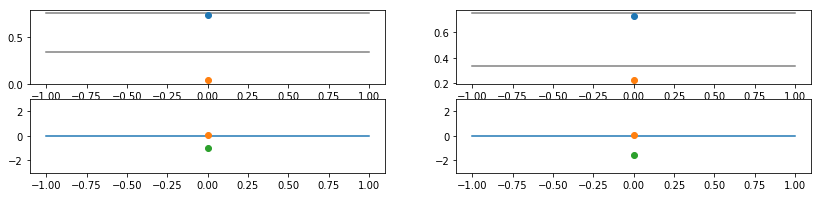

In [11]:
def sample_fakes(height): # only 2 or 3 valid for now
    assert height == 2 or height == 3
    
    fake_samples = []
    bases = get_samples(100, height=height - 1)
    ros = get_readouts(bases)
    for rg, stack in zip(ros, bases):
        zvar = spawn.init_noise(size=ZSIZE).to(device)
        hp = stack[-1].to(device)
        zout = spawn(rg, hp, zvar)
        fake_samples.append(stack + [zout.cpu()])
    return fake_samples

history = [sample_fakes(2)]
plot_distrib(history, height=2)

history = [sample_fakes(3)]
plot_distrib(history, height=3)

In [12]:
def train_level(iter, ln):
    assert ln == 2 or ln == 3
    
    spawn.train()
    readout.train()
    discrim.train()
    discrim_opt.zero_grad()
    readout.zero_grad()
    discrim.zero_grad()

    real_samples = get_samples(bhalf, height=ln, device=device)
    real_readouts = torch.stack(
        get_readouts(real_samples)).to(device)
    
    just_bases = get_samples(bhalf, height=ln-1, device=device)
    fake_samples = []
    base_readouts = get_readouts(just_bases) # dont propogate to generator
    for rg, stack in zip(base_readouts, just_bases):
        zvar = spawn.init_noise(size=ZSIZE)
        hvect = stack[-1]
        hchild = spawn(rg.to(device), hvect.to(device), zvar.to(device))
        hchild = hchild.detach()
        fake_samples.append(stack + [hchild])
    fake_readouts = get_readouts(fake_samples) # get readouts of built tree
    fake_readouts = torch.stack(fake_readouts).to(device)
    
    # -- Discrimination Training --
    real_guesses = discrim(real_readouts)
    fake_guesses = discrim(fake_readouts)
    discrim_loss = -torch.mean(real_guesses) + torch.mean(fake_guesses)
    discrim_loss.backward()
    if iter % 5 == 0: # only periodically adjust readout (for stability of discrim)
        readout_opt.step()
    else:
        discrim_opt.step()
        for p in discrim.parameters():
            p.data.clamp_(-0.01, 0.01)
#     for p in readout.parameters():
#         p.data.clamp_(-0.01, 0.01)
#     else:
#         
#         for p in discrim.parameters():
#             p.data.clamp_(-0.01, 0.01)
    
    real_score = score(torch.nn.Sigmoid()(real_guesses), real_labels)
    fake_score = score(torch.nn.Sigmoid()(fake_guesses), fake_labels)
    disc_score = (real_score + fake_score) / 2
    assert disc_score <= 1.0
    
    
    
    gen_loss = None
    if iter % 5 == 4:
        fake_samples = []
        just_bases = get_samples(bhalf, height=ln-1, device=device)
        base_readouts = get_readouts(just_bases)
        for rg, stack in zip(base_readouts, just_bases):
            rg = rg.detach() # Readout not learned here
            zvar = spawn.init_noise(size=ZSIZE)
            hvect = stack[-1]
            hchild = spawn(rg.to(device), hvect.to(device), zvar.to(device))
            fake_samples.append(stack + [hchild])
        fake_readouts = get_readouts(fake_samples) # TODO: make sure readout unchanged
        fake_readouts = torch.stack(fake_readouts).to(device)
        
        # -- Generator Training --
        gen_opt.zero_grad()
        gen_loss = -torch.mean(discrim(fake_readouts))
        gen_loss.backward()
        gen_opt.step()
        
    return discrim_loss.item(), None if gen_loss is None else gen_loss.item(), disc_score
#     return discrim_loss.item(), -1, disc_score
    

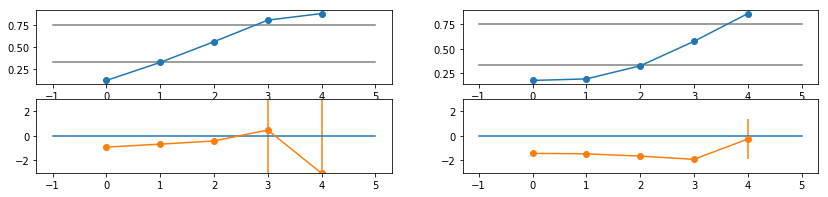

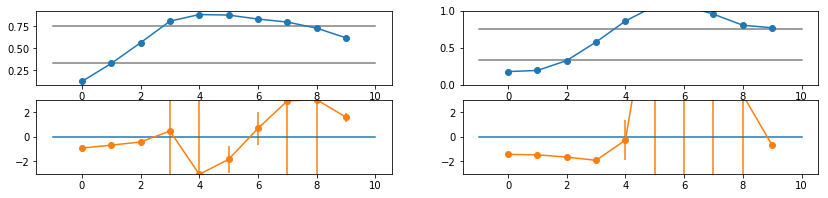

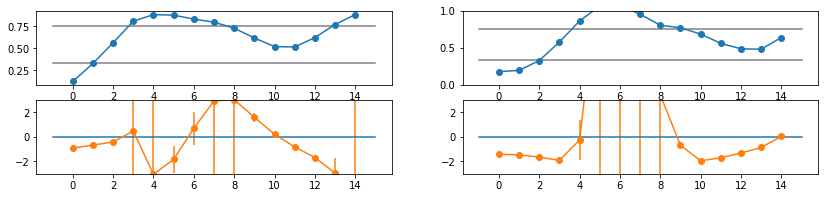

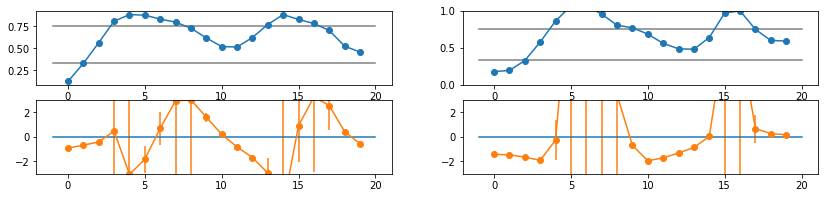

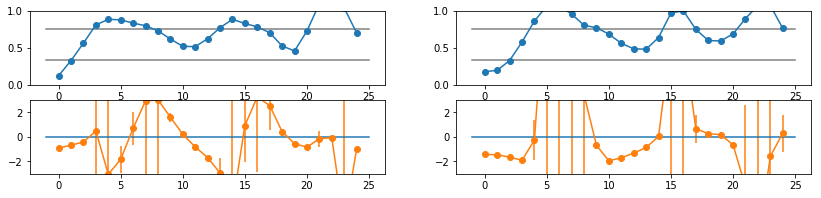

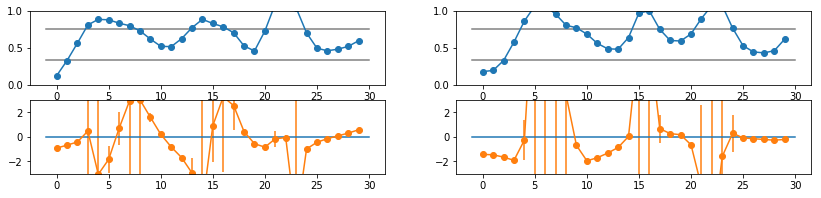

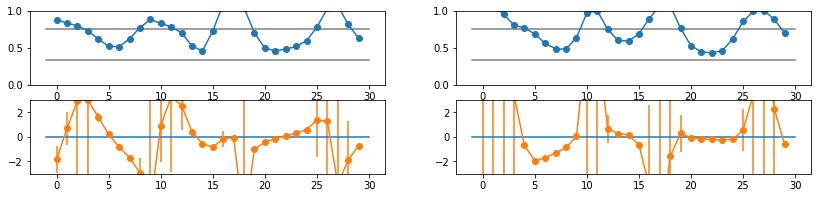

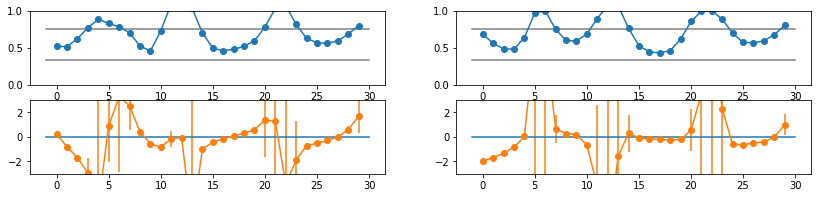

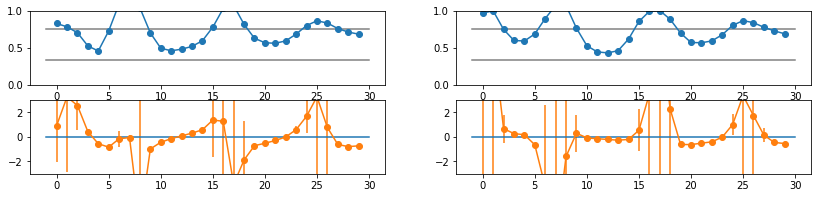

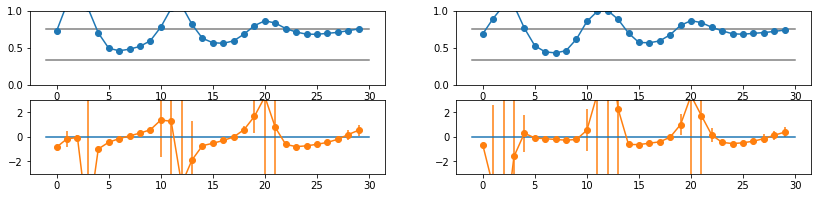

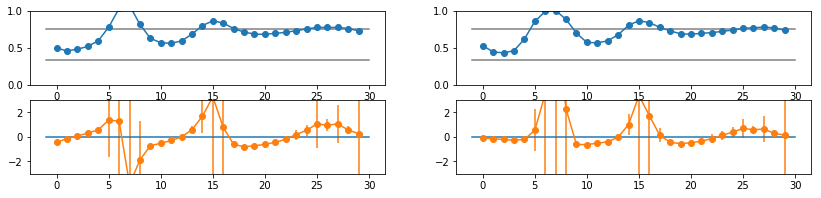

In [ ]:
history=[]
n_iters = 500 * 1000

for iter in range(1, n_iters + 1):
    
    discrim_loss, gen_loss, disc_score = train_level(iter, 2)

    if iter % 10 == 9:
        assert gen_loss is not None
        sys.stdout.write('[%d] Generate/L: %.5f  Discrim/L : %.5f  Score: %.2f   \r' % (
            iter,
            gen_loss,
            discrim_loss,
            disc_score))
    
    if iter % 100 == 99:
        spawn.eval()
        readout.eval()
        discrim.eval()
        preview = sample_fakes(height=2)
        history.append(preview)

    if iter % 500 == 499:        
        plot_distrib(history, height=2, recent=30)


In [ ]:
plot_distrib(history, height=2)
plot_distrib(history, height=2, recent=50)

In [ ]:
plt.figure(figsize=(14, 10))
for jj in range(2):
    for ii in range(spreview):
        ind = spreview*jj+ii
        plt.subplot(2, spreview, ind+1)
        plt.imshow(raster(history[-1][ind]), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

In [ ]:
real_samples = get_samples(50, height=2)
plt.figure(figsize=(14, 10))
for jj in range(2):
    for ii in range(spreview):
        ind = spreview*jj+ii
        plt.subplot(2, spreview, ind+1)
        plt.imshow(raster(real_samples[ind]), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()